### Problem 1x: check the STA for the stimulus on the other side (stimR)

In [1]:
import sys
import os
import h5py 
import scipy.io as sio
import pprint

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Data/'

       
import numpy as np
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
print(device)

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', 'checkpoints')

#%load_ext autoreload
#%autoreload 2

import NTdatasets.HN.HNdatasets as datasets

num_lags = 12

inclMUs = True #set false for now
fn = 'ki_0126_V2_py.mat'
data = datasets.HNdataset(filename=fn, datadir=datadir, drift_interval=90)
print(len(data), data.NC)

## Additional stimulus-processing information
print('For model-fitting, we can choose stimulus and time-embed to store in the data.stim varible')
 # this creates the stim variable
data.prepare_stim(which_stim='left', num_lags=num_lags)
print(data.stim.shape)

print('\nThe stimulus is flattened, but dimension information is in data.stim_dims')
print(data.stim_dims)
print('This is always stored by [channels, space0, space1, lags]\nIt can be reshaped as follows:' )
# All stimuli are Time embedding: 
# its flattened, and any stimulus can reshaped using data.stim_dims


print( data.stim.reshape([data.NT] + data.stim_dims).shape )

print( data.stim.reshape([-1, len(data.disp_list), num_lags]).shape )

Running on Computer: [wireless-10-104-47-95.umd.edu]
Invoking __init__.py for NDNT.utils
cpu
Save_dir = checkpoints
./Data/ ki_0126_V2_py.mat
Loaded ki_0126_V2_py.mat
190541 frames, 26 units, 870 trials with 192 frames each
190541 26
For model-fitting, we can choose stimulus and time-embed to store in the data.stim varible
torch.Size([190541, 132])

The stimulus is flattened, but dimension information is in data.stim_dims
[1, 11, 1, 12]
This is always stored by [channels, space0, space1, lags]
It can be reshaped as follows:
torch.Size([190541, 1, 11, 1, 12])
torch.Size([190541, 11, 12])


In [2]:
#sta = []
#for lag in range(0, num_lags):
#    lagged_stim = shift_vector(merged[:,0], lag)
#    sta.append(np.sum(lagged_stim * merged[:,1]) / np.sum(merged[:,1]))
#sta = np.array(sta)

# reshape X to be easier to work with and understand
X = data.stim.numpy().reshape([-1, 11, num_lags])[:,:,:]
R = data.robs.numpy()

X0 = data.stim.numpy().reshape([-1, 11, num_lags])[:,:,0] # reshape X0 to be Time x Disparities at Lag 0
R0 = data.robs.numpy()[:,0] # R at neuron 0
print(X0.shape, R0.shape)

# calculate the STA for a single neuron at lag 0 for a single disparity
xr = np.sum(X0[:,0].T * R0)
xsum = np.sum(X0[:,0])
print(X0[:10,0])
print(R0[:10])
print(xr / xsum)

(190541, 11) (190541,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 2. 3. 1. 2. 2. 1.]
0.44181925


### Preferred (when the choice was the one that was cued),
### vs.
### Null (when the choice was not the one that was cued?)

### In this case, because of the data setup, the default must be the preferred choice,
### Now, I need to look at the non-preferred (null) choice and plot it.

In [3]:
R_valid = R * data.dfs.numpy()

# for each disparity (each in a separate plot),
# show the STA for a single neuron (R0) over the 12 lags
neurons = {}
for neuron in range(0, 26): # go through each neuron
    stas = []
    for disparity in range(0, 11): # go through each disparity
        sta = []
        for lag in range(0, 12): # go through each lag
            # calculate the average firing rate for the neuron at that that disparity and lag
            bin_sum = np.sum(X[:, disparity, lag].T * R_valid[:, neuron]) # this is the sum of bins
            bin_count = np.sum(X[:, disparity, lag]) # this is the count of bins
            sta.append(bin_sum / bin_count)
        sta = np.array(sta) # NOTE: this is not the STA, only at a particular time point
        stas.append(sta)
    neurons[neuron] = np.array(stas)

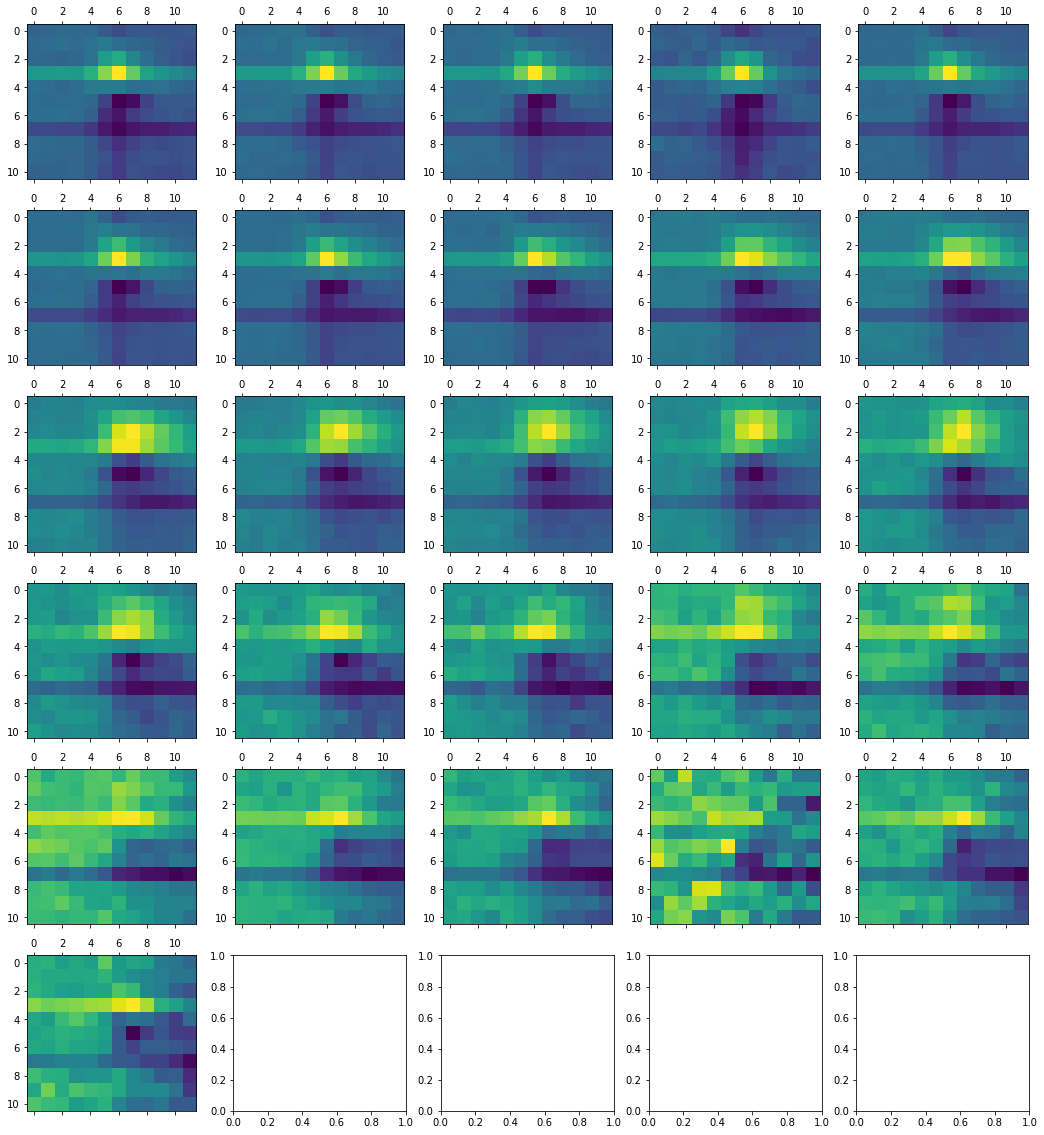

<Figure size 432x288 with 0 Axes>

In [4]:
# neurons <-- [neuron][disparity, lag]

# make a plot for each neuron and how it responds to the different disparities
fig, ax = plt.subplots(nrows=6, ncols=5)
fig.set_size_inches(18, 20, forward=True)

figraster = plt.figure()
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        neuron = i*len(row) + j
        if neuron < len(neurons):
            raster = neurons[neuron]
            col.matshow(raster) # plot how neuron 0 responds to the different disparities

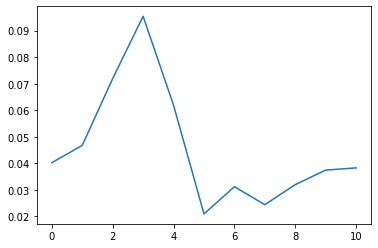

In [5]:
#        neurons[neuron][disparity, lag]
plt.plot(neurons[3][:,7])

# **PROBLEM 1X**

In [6]:
# TODO: subset the data for cued vs. uncued sides

# reshape X to be easier to work with and understand
X = data.stim.numpy().reshape([-1, 11, num_lags])[:,:,:]
R = data.robs.numpy()

# set invalid spikes in R to be 0
R = R * data.dfs.numpy()

X0 = data.stim.numpy().reshape([-1, 11, num_lags])[:,:,0] # reshape X0 to be Time x Disparities at Lag 0
R0 = data.robs.numpy()[:,0] # R at neuron 0
print(X0.shape, R0.shape)

# calculate the STA for a single neuron at lag 0 for a single disparity
xr = np.sum(X0[:,0].T * R0)
xsum = np.sum(X0[:,0])
print(X0[:10,0])
print(R0[:10])
print(xr / xsum)

# indices for the data associated with each trial
print(data.Ntr, len(data.block_inds))

# list of trials,
# each trial contains the indices of the data, X and R, for that trial
#data.block_inds[-1]

block_inds_cued_list = [block_ind_arr for cue, block_ind_arr in zip(data.TRcued, data.block_inds) if cue == 1]
block_inds_uncued_list = [block_ind_arr for cue, block_ind_arr in zip(data.TRcued, data.block_inds) if cue == -1]

# flatten the block_inds into flat lists of indices, instead of lists of arrays of indices
block_inds_cued = []
for block_ind_arr in block_inds_cued_list:
    block_inds_cued.extend(list(block_ind_arr))
    
block_inds_uncued = []
for block_ind_arr in block_inds_uncued_list:
    block_inds_uncued.extend(list(block_ind_arr))

Xcued = X[block_inds_cued]
Xuncued = X[block_inds_uncued]

Rcued = R[block_inds_cued]
Runcued = R[block_inds_uncued]

(190541, 11) (190541,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 2. 3. 1. 2. 2. 1.]
0.44181925
870 870


In [7]:
print(Xcued.shape, Xuncued.shape)
print(Rcued.shape, '   ', Runcued.shape)

(89361, 11, 12) (83780, 11, 12)
(89361, 26)     (83780, 26)


## CUED

In [8]:
# for each disparity (each in a separate plot),
# show the STA for a single neuron (R0) over the 12 lags
neurons_cued = {}
for neuron in range(0, 26): # go through each neuron
    stas = []
    for disparity in range(0, 11): # go through each disparity
        sta = []
        for lag in range(0, 12): # go through each lag
            # calculate the average firing rate for the neuron at that that disparity and lag
            bin_sum = np.sum(Xcued[:, disparity, lag].T * Rcued[:, neuron]) # this is the sum of bins
            bin_count = np.sum(Xcued[:, disparity, lag]) # this is the count of bins
            sta.append(bin_sum / bin_count)
        sta = np.array(sta) # NOTE: this is not the STA, only at a particular time point
        stas.append(sta)
    neurons_cued[neuron] = np.array(stas)

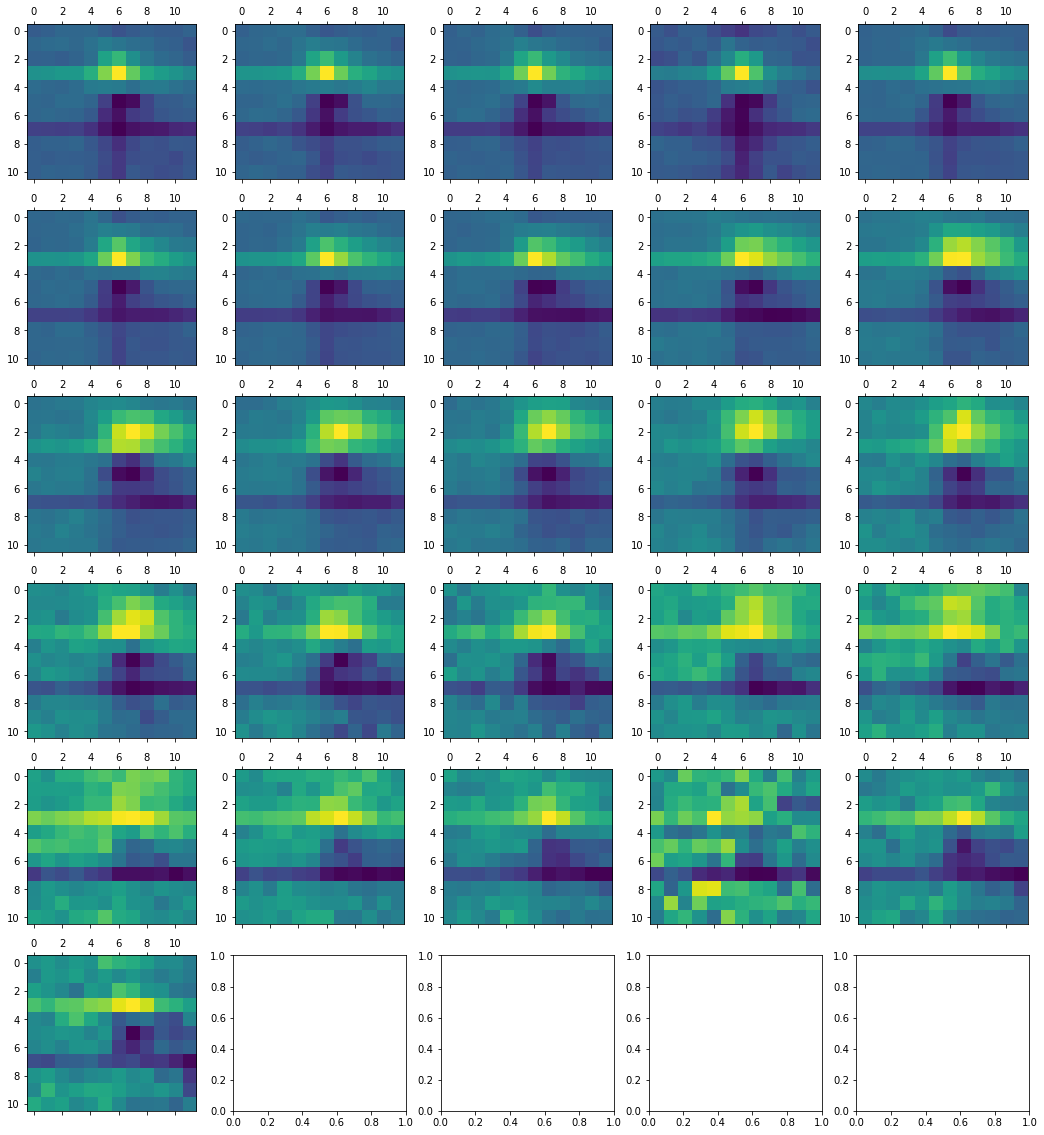

<Figure size 432x288 with 0 Axes>

In [9]:
# neurons <-- [neuron][disparity, lag]

# make a plot for each neuron and how it responds to the different disparities
fig, ax = plt.subplots(nrows=6, ncols=5)
fig.set_size_inches(18, 20, forward=True)

figraster = plt.figure()
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        neuron = i*len(row) + j
        if neuron < len(neurons_cued):
            raster = neurons_cued[neuron]
            col.matshow(raster) # plot how neuron 0 responds to the different disparities

## UNCUED

In [10]:
# for each disparity (each in a separate plot),
# show the STA for a single neuron (R0) over the 12 lags
neurons_uncued = {}
for neuron in range(0, 26): # go through each neuron
    stas = []
    for disparity in range(0, 11): # go through each disparity
        sta = []
        for lag in range(0, 12): # go through each lag
            # calculate the average firing rate for the neuron at that that disparity and lag
            bin_sum = np.sum(Xuncued[:, disparity, lag].T * Runcued[:, neuron]) # this is the sum of bins
            bin_count = np.sum(Xuncued[:, disparity, lag]) # this is the count of bins
            sta.append(bin_sum / bin_count)
        sta = np.array(sta) # NOTE: this is not the STA, only at a particular time point
        stas.append(sta)
    neurons_uncued[neuron] = np.array(stas)

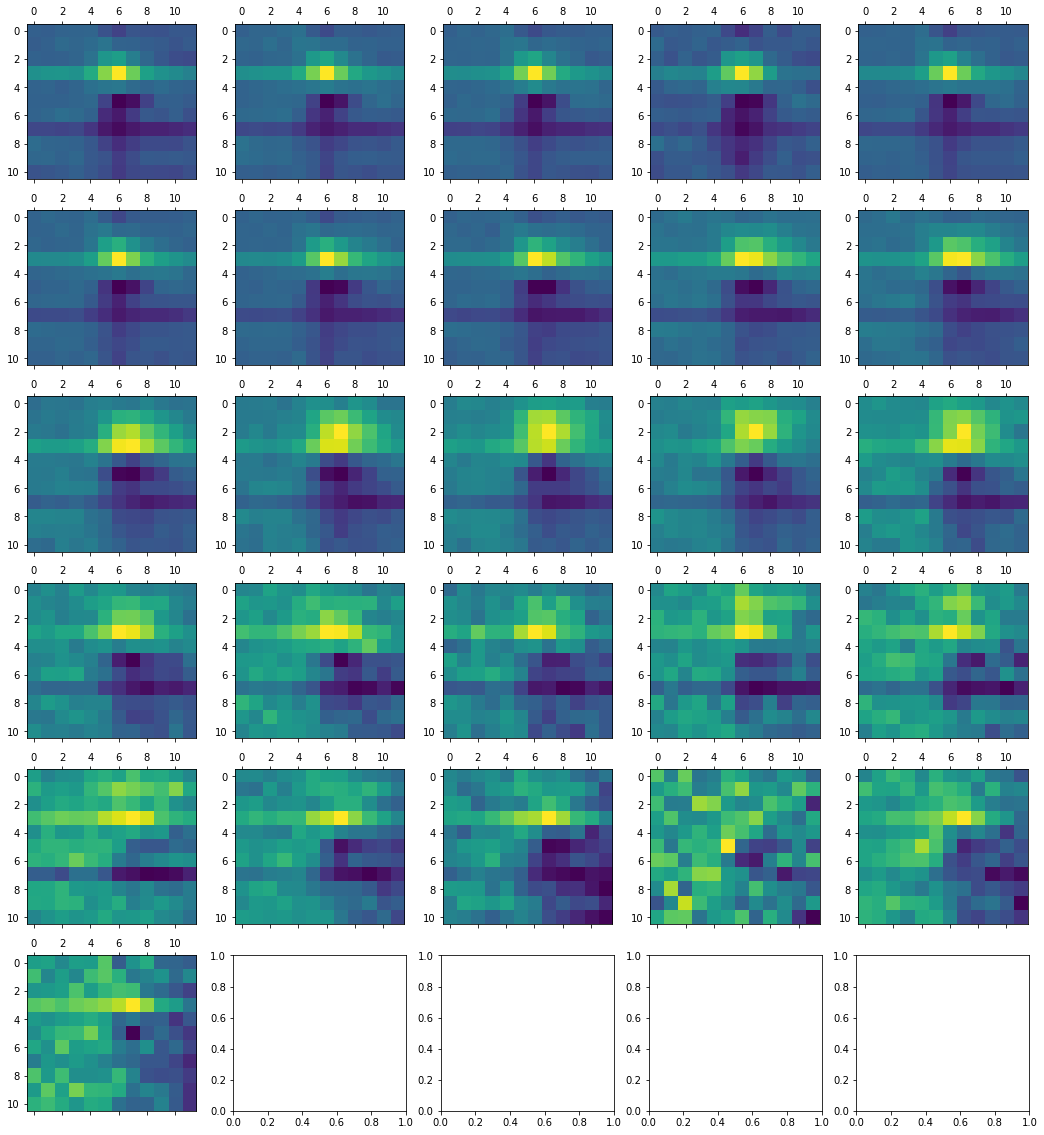

<Figure size 432x288 with 0 Axes>

In [11]:
# neurons <-- [neuron][disparity, lag]

# make a plot for each neuron and how it responds to the different disparities
fig, ax = plt.subplots(nrows=6, ncols=5)
fig.set_size_inches(18, 20, forward=True)

figraster = plt.figure()
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        neuron = i*len(row) + j
        if neuron < len(neurons_uncued):
            raster = neurons_uncued[neuron]
            col.matshow(raster) # plot how neuron 0 responds to the different disparities

## CUED vs. UNCUED

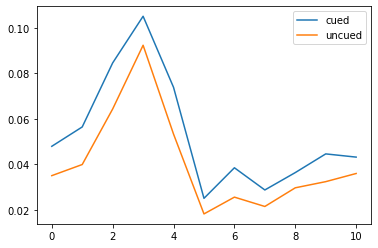

In [12]:
#        neurons[neuron][disparity, lag]
plt.plot(neurons_cued[3][:,7], label="cued")
plt.plot(neurons_uncued[3][:,7], label="uncued")
plt.legend()

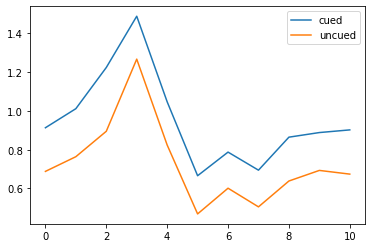

In [13]:
#        neurons[neuron][disparity, lag]
plt.plot(neurons_cued[4][:,7], label="cued")
plt.plot(neurons_uncued[4][:,7], label="uncued")
plt.legend()

# TODO: simplify calculation from Problem 1

In [14]:
# for each disparity (each in a separate plot),
# show the STA for a single neuron (R0) over the 12 lags
neurons = {}
for neuron in range(0, 26): # go through each neuron
    stas = []
    for disparity in range(0, 11): # go through each disparity
        sta = []
        for lag in range(0, 12): # go through each lag
            # calculate the average firing rate for the neuron at that that disparity and lag
            bin_sum = np.sum(X[:, disparity, lag].T * R[:, neuron]) # this is the sum of bins
            bin_count = np.sum(X[:, disparity, lag]) # this is the count of bins
            sta.append(bin_sum / bin_count)
        sta = np.array(sta) # NOTE: this is not the STA, only at a particular time point
        stas.append(sta)
    neurons[neuron] = np.array(stas)

In [15]:
X = data.stim
R = data.robs
print(X.shape, R.shape)

totals = np.matmul(X.T, R) # this creates the total spike count per disparity per neuron
print(X.shape, totals.shape)

torch.Size([190541, 132]) torch.Size([190541, 26])
torch.Size([190541, 132]) torch.Size([132, 26])


In [16]:
averages = totals / X.T

RuntimeError: The size of tensor a (26) must match the size of tensor b (190541) at non-singleton dimension 1